<a href="https://colab.research.google.com/github/adantra/nangs/blob/master/Difussion2D_xx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade git+https://github.com/adantra/nangs.git

  Cloning https://github.com/adantra/nangs.git to /tmp/pip-req-build-njpjkb2_
  Running command git clone -q https://github.com/adantra/nangs.git /tmp/pip-req-build-njpjkb2_


In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.9.0+cu102')

In [ ]:
device


'cuda'

In [ ]:
def perm(y):
  return 1+100*torch.exp(-(y-0.5)**2/0.1)

In [ ]:
alpha=1
class Difussion2d(PDE):
    def computePDELoss(self, inputs, outputs):
        p = outputs[:, 0]
        #y = torch.tensor(inputs[:,1])
        grads = self.computeGrads(p, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        # second order derivatives        
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0] 
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        return {'pde':alpha*dpdt - (dp2dx2 + dp2dy2)}

In [ ]:
class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx = grads[:, 0]
        return {'gradX': dpdx}

In [ ]:
class NeumannY(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdy = grads[:, 1]
        return {'gradX': dpdy}

In [ ]:
class PBC1(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        pbc = 0
        p = outputs[:, 0]
        return {'PBC': 10*(p-pbc)}

In [ ]:
class PBC0(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        pbc = 1
        p = outputs[:, 0]
        return {'PBC': 10*(p-pbc)}

In [ ]:
pde = Difussion2d(inputs=('x', 'y', 't'), outputs='p')

In [ ]:
# mesh 

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)
t = np.linspace(0,0.5,50)

mesh = Mesh({'x': x, 'y': y, 't':t}, device=device)
pde.set_mesh(mesh)

In [ ]:
from nangs import Dirichlet

In [ ]:
t0 = np.array([0])

In [ ]:
_x, _y = np.meshgrid(x, y)
#p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

In [ ]:
p0=np.zeros((len(x),len(y)))
p0[:]=1
p0[:,0]=0
#p0[47:53,47:53]=1

In [ ]:
p0.shape

(50, 50)

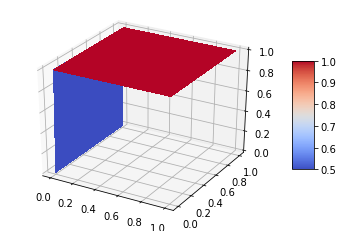

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(_x, _y, p0.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
initial_condition = Dirichlet({'x': x, 'y': y,'t':t0}, {'p': p0.reshape(-1)}, device=device, name="initial")

In [ ]:
pde.add_boco(initial_condition)
#p0=np.ones(len(y))
#p1=np.zeros(len(y))

In [ ]:
left = PBC1({'x': np.array([0]), 'y': y,'t':t}, name='left', device=device)
#left = Dirichlet({'x': x, 'y': y}, {'p': p0.reshape(-1)}, device=device, name="left")

In [ ]:
pde.add_boco(left)

In [ ]:
#right = PBC0({'x': np.array([1]), 'y': y, 't':t}, name='right', device=device)
#right = Dirichlet({'x': x[-1], 'y': y}, {'p': p1.reshape(-1)}, device=device, name="right")

In [ ]:
right = NeumannX({'x': x[-1], 'y': y,'t':t}, name='right', device=device)

In [ ]:
pde.add_boco(right)

In [ ]:

top = NeumannY({'x': x, 'y': y[-1],'t':t}, name='top', device=device)

In [ ]:
pde.add_boco(top)

In [ ]:
bottom = NeumannY({'x': x, 'y': y[-1],'t':t}, name='bottom', device=device)

In [ ]:
pde.add_boco(bottom)

In [ ]:
from nangs import MLP

BATCH_SIZE = 1024
LR = 1e-2
EPOCHS = 50
NUM_LAYERS = 3
NUM_HIDDEN = 50

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [ ]:
EPOCHS = 300
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [ ]:
pde.compile(mlp, optimizer, scheduler)

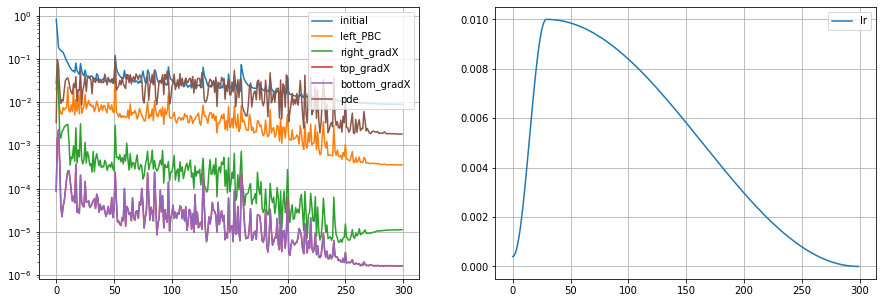

CPU times: user 1h 10min 13s, sys: 2min 5s, total: 1h 12min 18s
Wall time: 1h 11min 4s


In [ ]:

%time hist = pde.solve(EPOCHS, BATCH_SIZE)

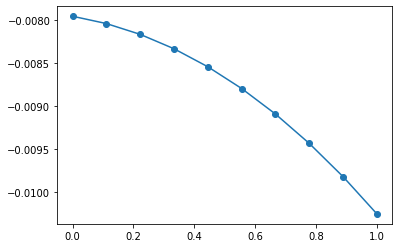

In [ ]:
te = 0.01
xe = np.linspace(0,1.,10)
ye = np.linspace(0,1,10)

_x, _y, _t = np.meshgrid(xe, ye, te)
eval_mesh = Mesh({'x': xe, 'y': ye, 't':te}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()
p5 = p.reshape((_y.shape[0],_x.shape[1]))
plt.plot(xe,p5[:,0],marker="o")

In [ ]:
p5.shape

(10, 10)

In [ ]:
def computep(te):
  #te = 0.01
  xe = np.linspace(0,1.5,20)
  ye = np.linspace(0,1,20)

  _x, _y, _t = np.meshgrid(xe, ye, te)
  eval_mesh = Mesh({'x': xe, 'y': ye, 't':te}, device=device)
  p = pde.eval(eval_mesh)
  p = p.cpu().numpy()
  p5 = p.reshape((_y.shape[0],_x.shape[1]))
  plt.plot(xe,p5[0],marker="o")
  plt.plot(xe,p5[-1],marker="o")

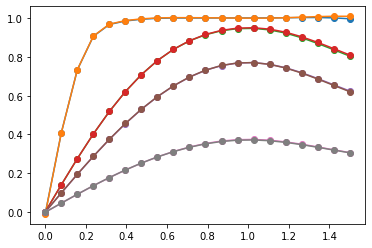

In [ ]:
for te in [0.01,0.1,0.2,0.5]:
  computep(te)

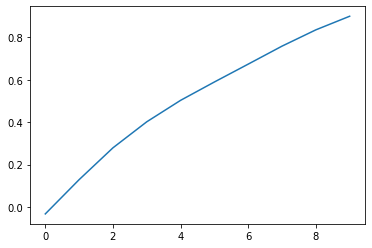

In [ ]:
plt.plot(p5[0])

In [ ]:
p0.shape

(100, 100)

In [ ]:
p1.shape

NameError: ignored

ValueError: ignored

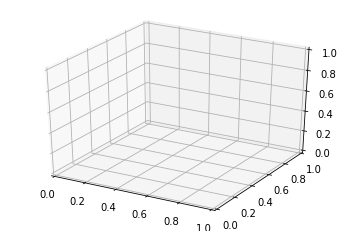

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(_x, _y, p1.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf = ax.plot_surface(_x, _y, p5.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
p1 = p.reshape((_y.shape[0],_x.shape[1]))

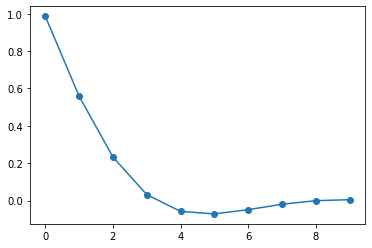

In [ ]:
#plt.plot(p00[0],color='b')
#plt.plot(p1[0],color='r')
#plt.plot(p2[0])
#plt.plot(p3[0])
#plt.plot(p4[0])
plt.plot(p5[0],marker="o")

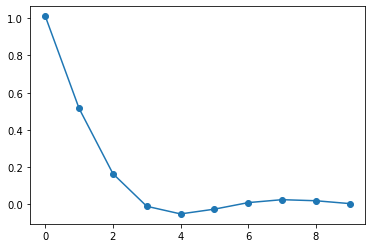

In [ ]:
plt.plot(p5[0],marker="o")

In [ ]:
p3[0][-1]

0.01346381

In [ ]:
ax.plot_surface(_x, _y, p.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)

ValueError: ignored

In [ ]:
p1.shape

(100, 100)

In [ ]:
_x.shape

(100, 100, 1)

In [ ]:
from copy import deepcopy

In [ ]:
mlp2=deepcopy(mlp)

In [ ]:
mlp2

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Sequential(
      (0): Sine()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Sequential(
      (0): Sine()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (3): Sequential(
      (0): Sine()
      (1): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)